# Imbalanced Data

#### Method：
 - Resampling: Undersampling/Oversampling
 - SMOTE
 - Class_Weight
#### IMPORTANT
---
 - Resample training dataset, do not resample testing dataset.


In [1]:
import io
import requests
from io import BytesIO
import gdown

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

## Data

In [2]:
url = 'https://drive.google.com/file/d/1_jRenWVqb1XHS1TqVechuNmsJlnqwEt8/view?usp=sharing'
file_id = url.split('/')[-2]
url = f'https://drive.google.com/uc?id={file_id}'
file = 'fraudTest.csv'
gdown.download(url, file, quiet=False)
data = pd.read_csv(file, index_col = 0)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1_jRenWVqb1XHS1TqVechuNmsJlnqwEt8
From (redirected): https://drive.google.com/uc?id=1_jRenWVqb1XHS1TqVechuNmsJlnqwEt8&confirm=t&uuid=6283d5f5-dd35-4a38-acd2-0083ca79cdc5
To: /Users/kang/A_Katrina/Machine Learning Study/fraudTest.csv
100%|████████████████████████████████████████| 150M/150M [00:02<00:00, 54.3MB/s]


In [3]:
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


#### Visualization

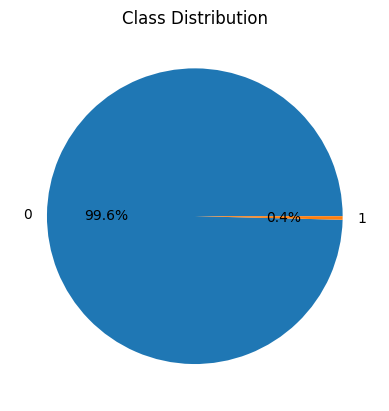

In [4]:
class_counts = data['is_fraud'].value_counts()
plt.pie(class_counts, labels = class_counts.index, autopct = '%1.1f%%')
plt.title('Class Distribution')
plt.show()

#### Preprocessing

In [5]:
seed = 45

In [6]:
# Split data into 80/20 in out of sample
data_train, data_test = train_test_split(data, test_size = .2, random_state = seed)

In [7]:
# Suppose we select 'category', 'amt', 'city_pop' as features
X_train = data_train[['category', 'amt', 'city_pop']]
y_train = data_train.is_fraud
X_test = data_test[['category', 'amt', 'city_pop']]
y_test = data_test.is_fraud

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444575 entries, 437893 to 399774
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   category  444575 non-null  object 
 1   amt       444575 non-null  float64
 2   city_pop  444575 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 13.6+ MB


In [9]:
# Preprocessing
cat_features = X_train.select_dtypes(exclude = ['float64', 'int64']).columns
num_features = X_train.select_dtypes(['float64', 'int64']).columns

cat_tf = Pipeline(steps = [('encoder', OneHotEncoder()), ('scaler', StandardScaler(with_mean = False))])
num_tf = Pipeline(steps = [('scaler', StandardScaler())])
col_tf = ColumnTransformer(transformers = [('num', num_tf, num_features), ('cat', cat_tf, cat_features)])

In [10]:
# Model
mod = LogisticRegression(random_state = seed)

## Baseline Model
---
Without resampling

In [11]:
pipe_baseline = Pipeline(steps = [('col_tf', col_tf), ('model', mod)])
pipe_baseline.fit(X_train, y_train)

Pipeline(steps=[('col_tf',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['amt', 'city_pop'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  Index(['category'], dtype='object'))])),
                ('model', LogisticRegression(random_state=45))])

In [12]:
y_pred_baseline = pipe_baseline.predict(X_test)
auc_baseline = roc_auc_score(y_test, y_pred_baseline)
CM_baseline = confusion_matrix(y_test, y_pred_baseline)
print(f'roc_auc_score: {auc_baseline:.4f}')
print(f'Confusion Matrix: \n{CM_baseline}')

roc_auc_score: 0.4999
Confusion Matrix: 
[[110708     23]
 [   413      0]]


## 1 Resampling

### a. Undersampling

In [13]:
from imblearn.under_sampling import RandomUnderSampler

In [14]:
rus = RandomUnderSampler(random_state = seed)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

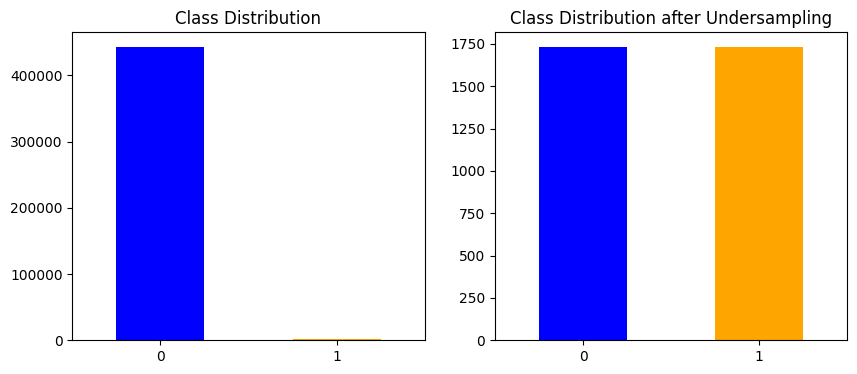

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

class_counts_train = y_train.value_counts()
class_counts_train.plot(kind='bar', ax = axs[0], color = ['blue', 'orange'])
axs[0].set_xticklabels(['0', '1'], rotation = 0)
axs[0].set_title('Class Distribution')

class_counts_rus = y_train_rus.value_counts()
class_counts_rus.plot(kind='bar', ax = axs[1], color = ['blue', 'orange'])
axs[1].set_xticklabels(['0', '1'], rotation = 0)
axs[1].set_title('Class Distribution after Undersampling')

plt.subplots_adjust(wspace=0.2)

plt.show()

In [16]:
class_counts_rus

0    1732
1    1732
Name: is_fraud, dtype: int64

In [17]:
pipe_rus = Pipeline(steps = [('col_tf', col_tf), ('model', mod)])
pipe_rus.fit(X_train_rus, y_train_rus)

Pipeline(steps=[('col_tf',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['amt', 'city_pop'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  Index(['category'], dtype='object'))])),
                ('model', LogisticRegression(random_state=45))])

In [18]:
y_pred_rus = pipe_rus.predict(X_test)
auc_rus = roc_auc_score(y_test, y_pred_rus)
CM_rus = confusion_matrix(y_test, y_pred_rus)
print(f'roc_auc_score: {auc_rus:.4f}')
print(f'Confusion Matrix: \n{CM_rus}')

roc_auc_score: 0.8329
Confusion Matrix: 
[[100547  10184]
 [   100    313]]


### b. Oversampling

In [19]:
from imblearn.over_sampling import RandomOverSampler

In [20]:
ros = RandomOverSampler(random_state = seed)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

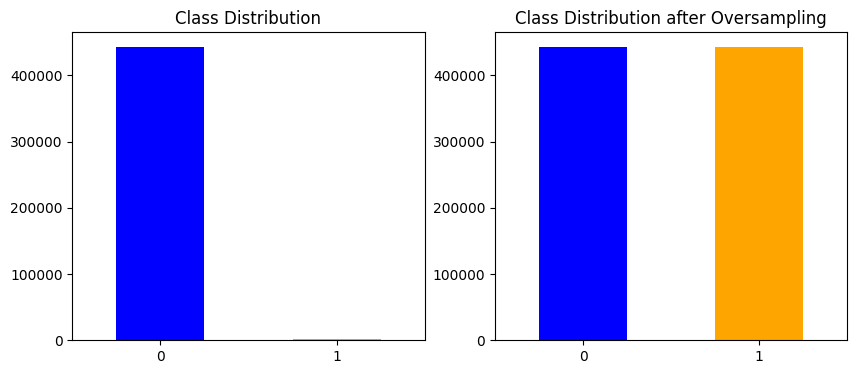

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

class_counts_train = y_train.value_counts()
class_counts_train.plot(kind='bar', ax = axs[0], color = ['blue', 'orange'])
axs[0].set_xticklabels(['0', '1'], rotation = 0)
axs[0].set_title('Class Distribution')

class_counts_ros = y_train_ros.value_counts()
class_counts_ros.plot(kind='bar', ax = axs[1], color = ['blue', 'orange'])
axs[1].set_xticklabels(['0', '1'], rotation = 0)
axs[1].set_title('Class Distribution after Oversampling')

plt.subplots_adjust(wspace=0.2)

plt.show()

In [22]:
pipe_ros = Pipeline(steps = [('col_tf', col_tf), ('model', mod)])
pipe_ros.fit(X_train_ros, y_train_ros)

Pipeline(steps=[('col_tf',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['amt', 'city_pop'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  Index(['category'], dtype='object'))])),
                ('model', LogisticRegression(random_state=45))])

In [23]:
y_pred_ros = pipe_ros.predict(X_test)
auc_ros = roc_auc_score(y_test, y_pred_ros)
CM_ros = confusion_matrix(y_test, y_pred_ros)
print(f'roc_auc_score: {auc_ros:.4f}')
print(f'Confusion Matrix: \n{CM_ros}')

roc_auc_score: 0.8355
Confusion Matrix: 
[[101101   9630]
 [   100    313]]


## 2 SMOT (Synthetic Minority Over-sampling Technique)

In [24]:
from imblearn.over_sampling import SMOTENC

In [25]:
smote = SMOTENC(categorical_features = [0], random_state = seed) # The categorical variable is column 0 of the X_train dataset
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

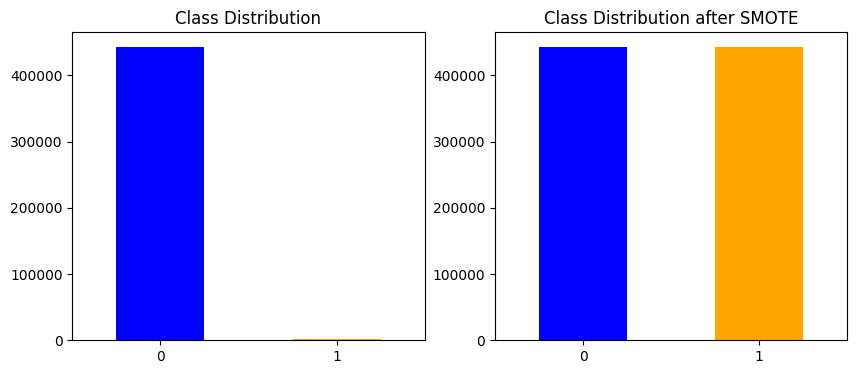

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

class_counts_train.plot(kind='bar', ax = axs[0], color = ['blue', 'orange'])
axs[0].set_xticklabels(['0', '1'], rotation = 0)
axs[0].set_title('Class Distribution')

class_counts_smote = y_train_smote.value_counts()
class_counts_smote.plot(kind='bar', ax = axs[1], color = ['blue', 'orange'])
axs[1].set_xticklabels(['0', '1'], rotation = 0)
axs[1].set_title('Class Distribution after SMOTE')

plt.subplots_adjust(wspace=0.2)

plt.show()

In [27]:
pipe_smote = Pipeline(steps = [('col_tf', col_tf), ('model', mod)])
pipe_smote.fit(X_train_smote, y_train_smote)

Pipeline(steps=[('col_tf',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['amt', 'city_pop'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  Index(['category'], dtype='object'))])),
                ('model', LogisticRegression(random_state=45))])

In [28]:
y_pred_smote = pipe_smote.predict(X_test)
auc_smote = roc_auc_score(y_test, y_pred_smote)
CM_smote = confusion_matrix(y_test, y_pred_smote)
print(f'roc_auc_score: {auc_smote:.4f}')
print(f'Confusion Matrix: \n{CM_smote}')

roc_auc_score: 0.8408
Confusion Matrix: 
[[102277   8454]
 [   100    313]]


## 3 Adjusting Class Weight

In [29]:
mod_cw = LogisticRegression(class_weight = 'balanced', random_state = seed)

In [30]:
pipe_cw = Pipeline(steps = [('col_tf', col_tf), ('model', mod_cw)])
pipe_cw.fit(X_train, y_train)

Pipeline(steps=[('col_tf',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['amt', 'city_pop'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  Index(['category'], dtype='object'))])),
                ('model',
                 LogisticRegression(class_weight='balanced', random_state=45))])

In [31]:
y_pred_cw = pipe_cw.predict(X_test)
auc_cw = roc_auc_score(y_test, y_pred_cw)
CM_cw = confusion_matrix(y_test, y_pred_cw)
print(f'roc_auc_score: {auc_cw:.4f}')
print(f'Confusion Matrix: \n{CM_cw}')

roc_auc_score: 0.8361
Confusion Matrix: 
[[101236   9495]
 [   100    313]]


## Comparison

In [32]:
methods = {'Baseline': auc_baseline,
           'Undersampling': auc_rus,
           'Oversampling': auc_ros,
           'SMOTE': auc_smote,
           'Class_Weight': auc_cw}
summary = pd.DataFrame.from_dict(methods, orient='index', columns=['auc_roc_score'])
summary

,auc_roc_score
Baseline,0.499896
Undersampling,0.832949
Oversampling,0.835451
SMOTE,0.840761
Class_Weight,0.836060
